In [1]:
import os
import sys
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from dotenv import load_dotenv
load_dotenv()

from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

import bambi as bmb
import arviz as az
import xarray as xr

import lightgbm as lgb

sys.path.append('../')

from sqlalchemy import create_engine
from database.queries import get_game_stats

warnings.filterwarnings('ignore', category=pd.errors.PerformanceWarning)
pd.set_option('display.max_columns', 100)

In [2]:
# loading up the postgres credentials
user = os.getenv('DB_USER')
password = os.getenv('DB_PASSWORD')
host = os.getenv('DB_HOST')
database = os.getenv('DB_NAME')
port = os.getenv('DB_PORT')

# # creating the URI for the database
URI = f'postgresql://{user}:{password}@{host}:{port}/{database}'

# # establishing a connection to the database
engine = create_engine(URI)

In [3]:
lee_sharpe_query = """
    select *
    from lee_sharpe
    where season >= 2012
"""

ls = pd.read_sql(lee_sharpe_query, URI)

In [4]:
# changing the names in the Lee Sharpe dataframe to match the names in the 
# nflfastr dataframe. This will allow us to combine data more easily, 
# using game_id. 

lv_home_condition = (ls['home_team'] == 'OAK') & (ls['season'] < 2020)
lv_away_condition = (ls['away_team'] == 'OAK') & (ls['season'] < 2020)
ls.loc[lv_home_condition, 'home_team'] = 'LV'
ls.loc[lv_away_condition, 'away_team'] = 'LV'

la_home_condition = (ls['home_team'] == 'STL') & (ls['season'] < 2016)
la_away_condition = (ls['away_team'] == 'STL') & (ls['season'] < 2016)
ls.loc[la_home_condition, 'home_team'] = 'LA'
ls.loc[la_away_condition, 'away_team'] = 'LA'

lac_home_condition = (ls['home_team'] == 'SD') & (ls['season'] < 2017)
lac_away_condition = (ls['away_team'] == 'SD') & (ls['season'] < 2017)
ls.loc[lac_home_condition, 'home_team'] = 'LAC'
ls.loc[lac_away_condition, 'away_team'] = 'LAC'

In [5]:
query = """
    select *
    from player_stats
    where season >=2012 and position = 'QB'
    order by season asc, week asc
"""
df = pd.read_sql(query, con=engine)

In [6]:
# getting game ids by week from the lee sharpe data. starting with home then
# using update to get the away team game ids
game_id_dict = ls.set_index(['season', 'week', 'home_team'])['game_id'].to_dict()
ls_gameid_away = ls.set_index(['season', 'week', 'away_team'])['game_id'].to_dict()

game_id_dict.update(ls_gameid_away)

# assigning game ids to the player stats dataframe using the game id dictionary
df['game_id'] = 'NA'
df['game_id'] = [game_id_dict[(s, w, t)] if (s, w, t) in game_id_dict else 'NA' for s, w, t in zip(df.season, df.week, df.recent_team)]

print("there are now", df[df['game_id'] == 'NA'].shape[0], "missing game ids")

there are now 0 missing game ids


In [7]:
# merging the lee sharpe data with the player stats data
df = df.merge(ls, how='left', on=['game_id', 'season', 'week'], validate='many_to_one')

# getting total passing yards for qbs for each game -- will use this
# later
team_yards_dict = (
    df
    .groupby(['season', 'week', 'recent_team'])['passing_yards']
    .sum()
    .to_dict()
)

# limit the dataset to only quarterbacks who started the game
cond = (df['player_id'] == df['home_qb_id']) | (df['player_id'] == df['away_qb_id'])

starters = df[cond].copy()
starters.reset_index(drop=True, inplace=True)

# are there any missing game ids in lee sharpe
set(ls.game_id.unique()).difference(set(starters.game_id.unique()))

set()

In [8]:
# getting team yards for each game
starters['team_passing_yards'] = (
    starters
    .apply(lambda x: team_yards_dict[(x['season'], x['week'], x['recent_team'])], axis=1)
)

# calculating fraction of total team yards
starters['frac_team_yards'] = starters['passing_yards'] / starters['team_passing_yards']

In [9]:
def ewm_player_statistics(data=None, alpha=None, min_periods=None):
    "calcs an exponentially weighted avg for a stat given an alpha and min period"
    data_mean = data.shift().ewm(alpha=alpha, min_periods=min_periods).mean()    
    return data_mean

In [10]:
# manually creating exponentially weighted moving averages for several statistics

starters['ewm_passing_yards'] = (
        starters.groupby('player_id')['passing_yards'].transform(lambda x: ewm_player_statistics(x, 0.08, 1))
    )

starters['ewm_passing_epa'] = (
        starters.groupby('player_id')['passing_epa'].transform(lambda x: x.shift().ewm(alpha=0.08, min_periods=1).mean())
    )

starters['ewm_passing_attempts'] = (
        starters.groupby('player_id')['attempts'].transform(lambda x: ewm_player_statistics(x, 0.08, 1))
    )

starters['ewm_pass_completions'] = (
        starters.groupby('player_id')['completions'].transform(lambda x: ewm_player_statistics(x, 0.08, 1))
    )

starters['ewm_completion_perc'] = starters['ewm_pass_completions'].div(starters['ewm_passing_attempts'])
starters['ewm_epa_per_att'] = starters['ewm_passing_epa'].div(starters['ewm_passing_attempts'])

In [15]:
# average passing yards by season, week
starters = starters[starters['season_type'] == 'REG'].copy()

passing_yards_sw = (
    starters
    .groupby(['season', 'week'])['passing_yards']
    .mean()
    .reset_index()
)

passing_yards_sw['season_expanding_mean'] = (
    passing_yards_sw
    .groupby('season')['passing_yards']
    .transform(lambda x: x.shift().expanding().mean())
    .fillna(method='ffill')
    .fillna(250)
)

py_sw = passing_yards_sw.set_index(['season', 'week'])['season_expanding_mean'].to_dict()

In [16]:
# adding the season expanding mean computed using weeks
# and the dictionary created above
starters['season_expanding_mean'] = (
    starters
    .apply(lambda row: py_sw[(row['season'], row['week'])], axis=1)
)

In [17]:
# counting games played - it'll be games played up until the row
# so 0 = first start
starters['games_played'] = starters.groupby('player_id').cumcount()

In [18]:
# creating adjusted statistics using mild shrinkage
shrinkage_constant = 3

# adding the shrinkage factor to the df
starters['shrinkage_factor'] = starters['games_played'] / (starters['games_played'] + shrinkage_constant)
# adjusting ewm passing yards
starters['adj_ewm_passing_yards'] = starters['shrinkage_factor'] * starters['ewm_passing_yards'] + \
                                    (1 - starters['shrinkage_factor']) * starters['season_expanding_mean']

# adjusting passing epa
starters['passing_epa_global_mean'] = starters['passing_epa'].expanding().mean().fillna(0.05)
starters['adj_ewm_passing_epa'] = starters['shrinkage_factor'] * starters['ewm_passing_epa'] + \
                                  (1 - starters['shrinkage_factor']) * starters['passing_epa_global_mean']
# calculating adjusted epa per attempt
starters['adj_ewm_epa_per_att'] = starters['adj_ewm_passing_epa'] / starters['ewm_passing_attempts']

In [19]:
# filling in nan values

starters['ewm_passing_attempts'].fillna(starters['ewm_passing_attempts'].median(), inplace=True)
starters['ewm_passing_yards'].fillna(starters['season_expanding_mean'], inplace=True)
starters['adj_ewm_passing_yards'].fillna(starters['adj_ewm_passing_yards'].median(), inplace=True)

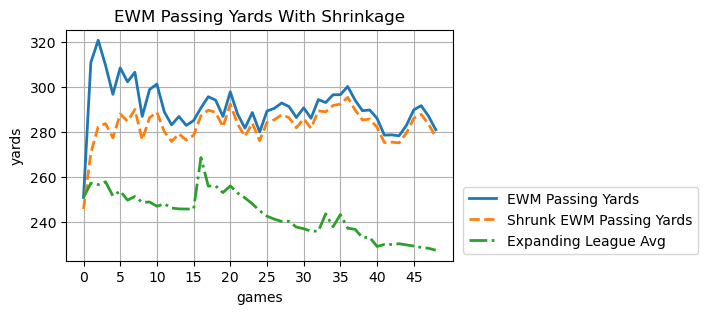

In [20]:
# plotting the effect of shrinkage. it keeps the first few 
# entries for each player close to the league average

plot_shrinkage = starters.query('player_name == "J.Herbert"').reset_index(drop=True)

fig, ax = plt.subplots(figsize=(5,3))

plot_shrinkage[['ewm_passing_yards', 'adj_ewm_passing_yards', 'season_expanding_mean']].plot(ax=ax, style=['-', '--', '-.'], linewidth=2.0)

plt.title('EWM Passing Yards With Shrinkage')
plt.xlabel('games')
plt.ylabel('yards')
plt.legend([
    'EWM Passing Yards', 
    'Shrunk EWM Passing Yards', 
    'Expanding League Avg'
], loc='lower right', bbox_to_anchor=(1.65, 0))

plt.xticks(np.arange(0, len(plot_shrinkage), 5))

plt.grid(True)
plt.show()

In [21]:
def calculate_trend(x):
    """
    local linear regression to find slope in performance
    """
    lr = LinearRegression()
    lr.fit(np.arange(len(x)).reshape(-1, 1), x)
    return lr.coef_[0]

In [22]:
# calculating the trend in performance over the last 20
# outings for each player

LOCAL_TREND_WINDOW = 20

starters['local_trend_ewm20'] = (
    starters
    .groupby('player_id')['adj_ewm_passing_yards']
    .transform(lambda x: x.rolling(LOCAL_TREND_WINDOW, min_periods=1).apply(calculate_trend))
)

In [23]:
# getting the team spread for each qb for each game
starters['team_spread'] = (
    starters
    .apply(lambda x: x['spread_line'] * -1 if x['recent_team'] == x['home_team'] else x['spread_line'], axis=1)
)


In [24]:
# getting the defensive team for each game and calculating 
# an exponentially weighted moving average for passing ep
# allowed - note, fix the neutral games!!!
starters['defteam'] = (
    starters
    .apply(lambda x: x['away_team'] if x['home_team'] == x['recent_team'] else x['away_team'], axis=1)
)

starters['defteam_ewm_passing_yards'] =(
    starters
    .groupby(['defteam'])['passing_yards']
    .transform(lambda x: x.shift().ewm(alpha=0.052, min_periods=1).mean())
    .fillna(starters['season_expanding_mean'])
)

# we should also apply shrinkage to defense - suboptimal implementation
def_shrinkage_constant = 7

starters['def_shrinkage_factor'] = starters['week'] / (starters['week'] + def_shrinkage_constant)
starters['adj_def_ewm_py'] = starters['def_shrinkage_factor'] * starters['defteam_ewm_passing_yards'] + \
                                  (1 - starters['def_shrinkage_factor']) * starters['season_expanding_mean']

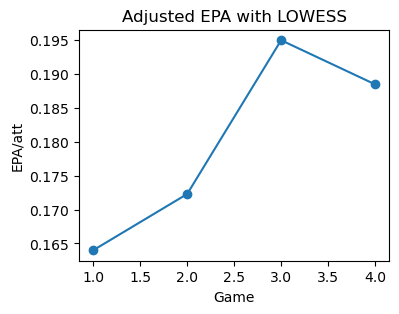

In [26]:
# plotting player performance over time using loess smoother
from statsmodels.nonparametric.smoothers_lowess import lowess

NAME = 'B.Purdy'
name_df = starters[starters['player_name'] == NAME].copy()

fig, ax = plt.subplots(figsize=(4,3))
lowess_smooth = lowess(name_df['adj_ewm_epa_per_att'], np.arange(len(name_df)), frac=0.7)

plt.plot(lowess_smooth[:,0], lowess_smooth[:,1])
plt.scatter(np.arange(len(name_df)), name_df['adj_ewm_epa_per_att'])
plt.title("Adjusted EPA with LOWESS")
plt.xlabel("Game")
plt.ylabel("EPA/att")
plt.show()

# Simple Linear Model, Simple Train-Test

In [22]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import HuberRegressor

In [23]:
# limiting the model to only regular season games
starters = starters[starters['season_type'] == 'REG'].copy()

In [24]:
# limiting quarterbacks to those with more than 5 games

games_played = starters.groupby('player_id').size().reset_index(name='count')
more_than_5 = games_played[games_played['count'] >= 5]['player_id'].tolist()

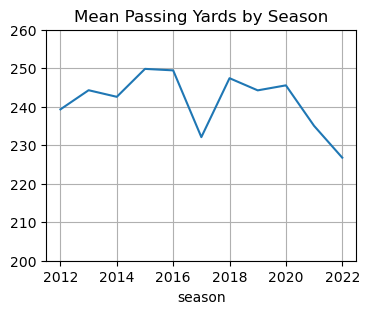

In [144]:
fig, ax = plt.subplots(figsize=(4,3))

starters.groupby('season')['passing_yards'].mean().plot()

plt.title("Mean Passing Yards by Season")
plt.ylim([200, 260])
plt.grid(True)
plt.show()

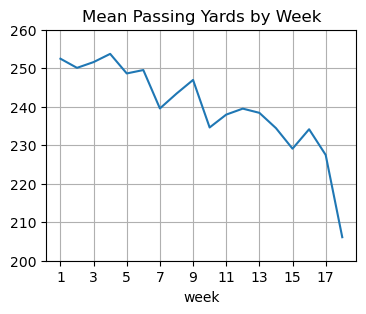

In [146]:
fig, ax = plt.subplots(figsize=(4,3))

starters.groupby('week')['passing_yards'].mean().plot()

plt.title("Mean Passing Yards by Week")
plt.ylim([200, 260])
plt.xticks(np.arange(1, 18, 2))
plt.grid(True)
plt.show()

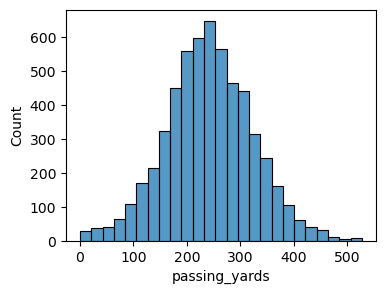

In [26]:
# now lets plot our target variable to see what the
# distribution looks like

fig, ax = plt.subplots(figsize=(4,3))

sns.histplot(starters['passing_yards'], bins=25)
plt.show()

In [27]:
# the distribution above looks like it may not be normal
# i'll do a quick check to see if the normal or the gamma
# fit the data better. we'll use scipy.stats and the 
# kolmogorov-smirnoff test to measure distance from 
# the fitted distribution

from scipy import stats

mu, std = stats.norm.fit(starters['passing_yards'])
d, p = stats.kstest(starters['passing_yards'], 'norm', args=(mu, std))

s, loc, scale = stats.gamma.fit(starters['passing_yards'])
gamma_d, gamma_p = stats.kstest(starters['passing_yards'], 'gamma', args=(s, loc, scale))

print("gamma k-statistic and pval:", gamma_d, gamma_p)
print("norm k-statistic and pval:", d, p)

gamma k-statistic and pval: 0.01485719248408024 0.16130967432756615
norm k-statistic and pval: 0.016619854195375816 0.08583024260125582


They're close, but the gamma is a slightly better fit.  
I'll fit norma, gamma, and huber linear models and see which has  
best performance.

In [28]:
from sklearn.linear_model import GammaRegressor, HuberRegressor
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import Pipeline

In [29]:
starters = starters[starters['passing_yards'] > 0].copy()

In [30]:
passing_yards_sw['expanding_week_avg'] = (
    passing_yards_sw
    .groupby('week')['passing_yards']
    .transform(lambda x: x.shift().expanding().mean())
)

null_condition = passing_yards_sw['expanding_week_avg'].isnull()

passing_yards_sw.loc[null_condition, 'expanding_week_avg'] = np.linspace(250, 215, 18)

In [31]:
season_week_avg = (
    passing_yards_sw
    .set_index(['season', 'week'])['expanding_week_avg']
    .to_dict()
)

starters['exp_week_avg'] = starters.apply(lambda x: season_week_avg[(x['season'], x['week'])], axis=1)

In [32]:
features = ['adj_ewm_passing_yards', 'ewm_passing_attempts',
          'wind', 'passing_yards', 'temp', 'week', 
          'total_line', 'team_spread', 'adj_def_ewm_py', 
           'local_trend_ewm20', 'season_expanding_mean']

model_df = starters[features].copy()
model_df['wind'] = model_df['wind'].fillna(0)
model_df['temp'] = model_df['temp'].fillna(72)
model_df['week_squared'] = model_df['week'] ** 2
model_df['adj_def_ewm_py'] = np.log(model_df['adj_def_ewm_py'])
model_df.dropna(subset=['adj_ewm_passing_yards'], inplace=True)

numeric_cols = model_df.select_dtypes('number').columns

scaler = StandardScaler()
model = RidgeCV(alphas=[0.1, 1, 10, 100, 500, 1000])
gamma_model = GammaRegressor(alpha=0)
huber_model = HuberRegressor(alpha=5, max_iter=50, epsilon=1.15)

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', model)
])

pipeline_gamma = Pipeline([
    ('scaler', StandardScaler()),
    ('gamma_model', gamma_model)
])

pipeline_huber = Pipeline([
    ('scaler', StandardScaler()),
    ('huber_model', huber_model)
])

X = model_df.drop('passing_yards', axis=1)

y = model_df['passing_yards']

X_train, X_test = X.iloc[:4000].copy(), X.iloc[4000:].copy()
y_train, y_test = y.iloc[:4000].copy(), y.iloc[4000:].copy()

# ordinary model training
pipeline.fit(X_train, y_train)
pipeline_gamma.fit(X_train, y_train)
pipeline_huber.fit(X_train, y_train)

# the cross validation score calcs using time series
splitter = TimeSeriesSplit(n_splits=15)

ridge_scores = cross_val_score(pipeline, X, y, cv=splitter, scoring='neg_mean_absolute_error')
gamma_scores = cross_val_score(pipeline_gamma, X, y, cv=splitter, scoring='neg_mean_absolute_error')
huber_scores = cross_val_score(pipeline_huber, X, y, cv=splitter, scoring='neg_mean_absolute_error')

In [33]:
# the cross validation scores with the time series split
score_comparison = (
    pd.DataFrame(ridge_scores, columns=['ridge'])
    .join(pd.DataFrame(gamma_scores, columns=['gamma']))
    .join(pd.DataFrame(huber_scores, columns=['huber']))
)

print("cross val score:")
print(score_comparison.mean() * -1)

cross val score:
ridge    58.944677
gamma    59.828292
huber    58.728348
dtype: float64


In [34]:
# creating a dataframe with the model params
model_params_df = pd.DataFrame({x:y for x, y in zip(X.columns, pipeline.named_steps['model'].coef_)}, index=[0])
model_params_df.insert(0, 'intercept', model.intercept_)

# how did this simple model do on the simple test set?
# it does beat the ewm for passing yards on its own
residuals = y_test - pipeline.predict(X_test)

print("the mean of the residuals is:", residuals.mean())
print("mae:", mean_absolute_error(y_test, pipeline_huber.predict(X_test)))
print("mse:", mean_squared_error(y_test, pipeline_huber.predict(X_test)))

the mean of the residuals is: -8.988040308659272
mae: 58.025089213497715
mse: 5487.171162692509


In [35]:
weeks = starters['week'].values
seasons = starters['season'].values
starters['season_week'] = starters['season'].astype(str) + '_' + starters['week'].astype(str)
unique_weeks = starters['season_week'].unique()

starters = pd.get_dummies(starters, columns=['week', 'season']).copy()

# Training Fresh Model Each Week  

And using it to predict on the next week.

Surprisingly, the errors of this process are not on net better

In [36]:
numeric_columns = ['adj_ewm_passing_yards', 'ewm_passing_attempts', 'wind', 'temp',
                   'total_line', 'team_spread', 'adj_def_ewm_py',
                   'local_trend_ewm20']

week_columns = [x for x in starters.columns if 'week_' in x]
season_columns = [x for x in starters.columns if 'season_2' in x]

feature_columns = numeric_columns + week_columns + season_columns

In [158]:
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import ElasticNetCV

In [ ]:
starters['week'] = weeks
starters['season'] = seasons
starters['preds'] = 0
starters['train_max'] = 'training'
starters['huber_preds'] = 0
starters['en_preds'] = 0

models = {}

for year_week in range(50, len(unique_weeks) - 1):
    
    season = int(unique_weeks[year_week].split('_')[0])
    week = int(unique_weeks[year_week].split('_')[1])
    condition = (starters['season'] <= season) & (starters['week'] <= week)
    
    df_ = starters[condition].copy()
    df_['wind'] = df_['wind'].fillna(0)
    df_['temp'] = df_['temp'].fillna(72)
    df_['week_squared'] = df_['week'] ** 2
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_columns)
        ], remainder='passthrough')
    
    model_ = Pipeline(steps=[('preprocessor', preprocessor),
                             ('model', RidgeCV(alphas=[10, 100, 200, 500, 1000]))])
    
    huber_model_ = Pipeline(steps=[('preprocessor', preprocessor),
                                   ('huber_model', HuberRegressor(alpha=5, max_iter=50, epsilon=1.15))])
    
    
    elasticnet_model_ = Pipeline(steps=[('preprocessor', preprocessor),
                                    ('elasticnet_model', ElasticNetCV(alphas=[0.1, 1, 10, 100], l1_ratio=[.1, .5, .7, .9, .95, .99, 1]))])
    
    X = df_.drop(columns='passing_yards')
    y = df_['passing_yards'].values
    
    model_.fit(X[feature_columns], y)
    models[year_week] = model_
    huber_model_.fit(X[feature_columns], y)
    elasticnet_model_.fit(X[feature_columns], y)
    
    pred_season = int(unique_weeks[year_week + 1].split('_')[0])
    pred_week = int(unique_weeks[year_week + 1].split('_')[1])
    pred_condition = (starters['season'] == pred_season) & (starters['week'] == pred_week)
    
    pred_df_ = starters[pred_condition].copy()
    pred_df_['wind'] = pred_df_['wind'].fillna(0)
    pred_df_['temp'] = pred_df_['temp'].fillna(72)
    pred_df_['week_squared'] = pred_df_['week'] ** 2
    
    preds = model_.predict(pred_df_[feature_columns])
    huber_preds = huber_model_.predict(pred_df_[feature_columns])
    en_preds = elasticnet_model_.predict(pred_df_[feature_columns])

    starters.loc[pred_condition, 'en_preds'] = en_preds
    starters.loc[pred_condition, 'huber_preds'] = huber_preds
    starters.loc[pred_condition, 'preds'] = preds
    starters.loc[pred_condition, 'train_max'] = unique_weeks[year_week]

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\sklearn\linear_model\_huber.py:342: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\sklearn\linear_model\_huber.py:342: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\sklearn\linear_model\_huber.py:342: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\sklearn\linear_model\_huber.py:342: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\sklearn\linear_model\_huber.py:342: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\sklearn\linear_model\_huber.py:342: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\sklearn\linear_model\_huber.py:342: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\sklearn\linear_model\_huber.py:342: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\sklearn\linear_model\_huber.py:342: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\sklearn\linear_model\_huber.py:342: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\sklearn\linear_model\_huber.py:342: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\sklearn\linear_model\_huber.py:342: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/

In [160]:
no_zero = starters[starters['preds'] != 0].copy()
no_zero['residual'] = no_zero['preds'] - no_zero['passing_yards']
no_zero['huber_residual'] = no_zero['huber_preds'] - no_zero['passing_yards']

# no_zero = no_zero[no_zero.index.isin(X_test.index)].copy()

print('overall MSE of ridge models trained up to each week:',
      mean_squared_error(no_zero['passing_yards'], no_zero['preds'])
     )

print('overall MSE of huber models trained up to each week:',
      mean_squared_error(no_zero['passing_yards'], no_zero['huber_preds'])
     )

print("average residuals ridge:", no_zero['residual'].mean())
print("average residuals huber:", no_zero['huber_residual'].mean())

overall MSE of ridge models trained up to each week: 5616.076558246252
overall MSE of huber models trained up to each week: 5591.325984314448
average residuals ridge: 8.315088454543883
average residuals huber: -1.2635973267385363


In [161]:
from sklearn.model_selection import KFold, cross_val_score
splitter = KFold(n_splits=65, shuffle=True)

oof = np.zeros(len(no_zero))

X_ensemble = no_zero[['huber_preds', 'preds', 'en_preds']].copy().reset_index(drop=True)
y_ensemble = no_zero['passing_yards'].values


for train, val in splitter.split(X_ensemble, y_ensemble):
    
    train_x = X_ensemble.iloc[train]
    train_y = y_ensemble[train]
    
    val_x = X_ensemble.iloc[val]
    
    model_ = LinearRegression()
    model_.fit(train_x, train_y)

    preds = model_.predict(val_x)    
    oof[val] = preds    

print("mse of ensemble:", mean_squared_error(y_ensemble, oof))
print("avg residuals of ensemble:", (y_ensemble - oof).mean())

mse of ensemble: 5512.609781228952
avg residuals of ensemble: -0.003232651385978788


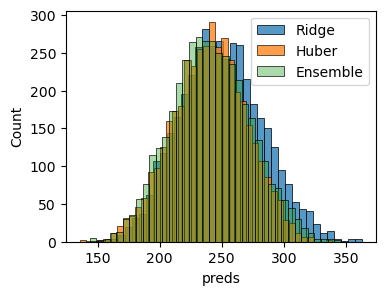

In [162]:
fig, ax = plt.subplots(figsize=(4,3))

sns.histplot(no_zero['preds'], label='Ridge')
sns.histplot(no_zero['huber_preds'], label='Huber')
sns.histplot(oof, label='Ensemble', alpha=0.4)
plt.legend()
plt.show()

In [168]:
no_zero['ensemble_preds'] = oof
no_zero['ensemble_residual'] = no_zero['passing_yards'] - no_zero['ensemble_preds']

In [169]:
from scipy.stats import ttest_1samp

t, p = ttest_1samp(no_zero['huber_residual'], 0)
print("the t-statistic and p-value of the huber residuals are:", t, p)

t2, p2 = ttest_1samp(no_zero['ensemble_residual'], 0)
print("the t-statistic and p-value of the ensemble residuals are:", t2, p2)

the t-statistic and p-value of the huber residuals are: -1.0886418545852088 0.27637508212007333
the t-statistic and p-value of the ensemble residuals are: -0.0028044775274403562 0.9977624884400618


In [193]:
huber_coef = huber_model_.named_steps['huber_model'].coef_
en_coef = elasticnet_model_.named_steps['elasticnet_model'].coef_
ridge_coef = model_.named_steps['model'].coef_

coef_df = pd.DataFrame({'huber' : huber_coef, 'en' : en_coef, 'ridge' : ridge_coef})
coef_df.index = feature_columns

coef_df

,huber,en,ridge
adj_ewm_passing_yards,9.611735,10.276113,10.886654
ewm_passing_attempts,8.022335,7.079371,8.677644
wind,-4.004052,-3.046230,-3.158523
temp,3.051640,5.682364,6.668487
total_line,11.182724,13.295571,15.496123
team_spread,-7.330452,-7.824940,-9.537701
adj_def_ewm_py,1.556496,1.543548,1.885326
local_trend_ewm20,-2.672323,-1.367058,-3.898845
exp_week_avg,0.989133,0.269139,-0.659364
week_1,0.503996,0.000000,24.098689
